In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa
from collections import Counter
from obspy.imaging.cm import viridis_white_r

df_gpt4o_mini = pd.read_pickle(r'C:\Users\Thales Henrique\Documents\openai\data\full_results_with_bias_analysis_gpt4.pkl')
df_gpt4o_mini_fewshot = pd.read_pickle(r'C:\Users\Thales Henrique\Documents\openai\data\full_results_with_bias_analysis_gpt-4o-mini_fewshot.pkl')
df_gpt4o = pd.read_pickle(r'C:\Users\Thales Henrique\Documents\openai\data\full_results_with_bias_analysis_gpt-4o.pkl')
df_gpt4o_fewshot = pd.read_pickle(r'C:\Users\Thales Henrique\Documents\openai\data\full_results_with_bias_analysis_gpt-4o_fewshot.pkl')

## Comparação dos Modelos

### Kamala Harris

In [2]:
label_to_idx = {'positive' : 0, 'negative' : 1, 'neutral': 2, 'not_mentioned': 3}

def get_outlets_dict(df):
    outlets_list = ['abc', 'apnews', 'cbs', 'cnn', 'fox', 'nbc', 'newsmax', 'newsweek', 'nypost', 'vox']
    outlets_dict = {}
    for outlet in outlets_list:
        outlets_dict[outlet] = {'harris_positive':0, 'harris_negative':0, 'harris_neutral':0, 'harris_total':0, \
                                'trump_positive':0, 'trump_negative':0, 'trump_neutral':0, 'trump_total':0 }
    #print(outlets_dict)
    df['harris_stance'] = ''
    df['trump_stance'] = ''
    
    for i, row in df.iterrows():
        outlet = row['ID'].split('-')[0]
        stances =  row['bias_analysis'].split('\n')
        #print(stances)
    
        if 'positive' in stances[0]:
            harris_stance = 'positive'
            outlets_dict[outlet]['harris_positive'] += 1
            outlets_dict[outlet]['harris_total'] += 1
        elif 'negative' in stances[0]:
            harris_stance = 'negative'
            outlets_dict[outlet]['harris_negative'] += 1
            outlets_dict[outlet]['harris_total'] += 1
        elif 'neutral' in stances[0]:
            harris_stance = 'neutral'
            outlets_dict[outlet]['harris_neutral'] += 1
            outlets_dict[outlet]['harris_total'] += 1
        else:
            harris_stance = 'not_mentioned'
    
    
        if 'positive' in stances[-1]:
            trump_stance = 'positive'
            outlets_dict[outlet]['trump_positive'] += 1
            outlets_dict[outlet]['trump_total'] += 1
        elif 'negative' in stances[-1]:
            trump_stance = 'negative'
            outlets_dict[outlet]['trump_negative'] += 1
            outlets_dict[outlet]['trump_total'] += 1
        elif 'neutral' in stances[-1]:
            trump_stance = 'neutral'
            outlets_dict[outlet]['trump_neutral'] += 1
            outlets_dict[outlet]['trump_total'] += 1
        else:
            trump_stance = 'not_mentioned'
    
        df.loc[i,'harris_stance'] = label_to_idx[harris_stance]
        df.loc[i,'trump_stance'] = label_to_idx[trump_stance]
    return outlets_dict
    
outlets_dict_gpt4o_mini = get_outlets_dict(df_gpt4o_mini)
outlets_dict_gpt4o_mini_fewshot = get_outlets_dict(df_gpt4o_mini_fewshot)
outlets_dict_gpt4o = get_outlets_dict(df_gpt4o)
outlets_dict_gpt4o_fewshot = get_outlets_dict(df_gpt4o_fewshot)

In [3]:
harris_model1 = df_gpt4o_mini['harris_stance'].to_list()
harris_model2 = df_gpt4o_mini_fewshot['harris_stance'].to_list()
harris_model3 = df_gpt4o['harris_stance'].to_list()
harris_model4 = df_gpt4o_fewshot['harris_stance'].to_list()
harris_models = [harris_model1, harris_model2, harris_model3, harris_model4]

harris_predictions = np.vstack([harris_model1, harris_model2, harris_model3, harris_model4]).T
harris_all_agree = (harris_predictions == harris_predictions[:, 0][:, None]).all(axis=1)
harris_indexes = np.where(harris_all_agree)[0]

In [4]:
harris_model1_adjusted = []
harris_model2_adjusted = []
harris_model3_adjusted = []
harris_model4_adjusted = []

for i in range(0, len(df_gpt4o_mini)):
    if harris_model1[i] == harris_model2[i]:
        if harris_model1[i] == harris_model3[i]:
            if harris_model1[i] == harris_model4[i]:
                if harris_model1[i] == 3:
                    continue
    harris_model1_adjusted.append(df_gpt4o_mini.iloc[i]['harris_stance'])
    harris_model2_adjusted.append(df_gpt4o_mini_fewshot.iloc[i]['harris_stance'])
    harris_model3_adjusted.append(df_gpt4o.iloc[i]['harris_stance'])
    harris_model4_adjusted.append(df_gpt4o_fewshot.iloc[i]['harris_stance'])
                    
harris_models_adjusted = [harris_model1_adjusted, harris_model2_adjusted, harris_model3_adjusted, harris_model4_adjusted]
harris_predictions_adjusted = np.vstack([harris_model1_adjusted, harris_model2_adjusted, harris_model3_adjusted, harris_model4_adjusted]).T

harris_all_agree_adjusted = (harris_predictions_adjusted  == harris_predictions_adjusted [:, 0][:, None]).all(axis=1)
harris_raw_agreement_adjusted  = harris_all_agree_adjusted.mean()

n_models = len(harris_models_adjusted)
harris_pairwise_agreement_adjusted = np.zeros((n_models, n_models))
print(f'Percentage of unanimity (all models agree on label): {harris_raw_agreement_adjusted:.4f}')


for i in range(n_models):
    for j in range(i, n_models):
        # Proportion of items where model i and j agree
        cohen = cohen_kappa_score(harris_models_adjusted[i], harris_models_adjusted[j])
        harris_pairwise_agreement_adjusted[i][j] = cohen
        harris_pairwise_agreement_adjusted[j][i] = cohen

print("Pairwise Cohen's Kappa Scores for Kamala Harris:")
print(harris_pairwise_agreement_adjusted)

Percentage of unanimity (all models agree on label): 0.2774
Pairwise Cohen's Kappa Scores for Kamala Harris:
[[1.         0.81790737 0.21052012 0.58822206]
 [0.81790737 1.         0.21961668 0.63661805]
 [0.21052012 0.21961668 1.         0.25584554]
 [0.58822206 0.63661805 0.25584554 1.        ]]


In [5]:
n_items = harris_predictions_adjusted.shape[0]
n_labels = 4

harris_freq_matrix = np.zeros((n_items, n_labels), dtype=int)
for i, row in enumerate(harris_predictions_adjusted):
    for label in row:
        harris_freq_matrix[i, label] += 1
        
kappa = fleiss_kappa(harris_freq_matrix, method='fleiss')
print(f"Fleiss' Kappa for Kamala Harris Stance Detection: {kappa:.4f}")

Fleiss' Kappa for Kamala Harris Stance Detection: 0.4049


### Donald Trump

In [6]:
trump_model1 = df_gpt4o_mini['trump_stance'].to_list()
trump_model2 = df_gpt4o_mini_fewshot['trump_stance'].to_list()
trump_model3 = df_gpt4o['trump_stance'].to_list()
trump_model4 = df_gpt4o_fewshot['trump_stance'].to_list()
trump_models = [trump_model1, trump_model2, trump_model3, trump_model4]

trump_predictions = np.vstack([trump_model1, trump_model2, trump_model3, trump_model4]).T
trump_all_agree = (trump_predictions == trump_predictions[:, 0][:, None]).all(axis=1)
trump_indexes = np.where(trump_all_agree)[0]

In [7]:
trump_model1_adjusted = []
trump_model2_adjusted = []
trump_model3_adjusted = []
trump_model4_adjusted = []

for i in range(0, len(df_gpt4o_mini)):
    if trump_model1[i] == trump_model2[i]:
        if trump_model1[i] == trump_model3[i]:
            if trump_model1[i] == trump_model4[i]:
                if trump_model1[i] == 3:
                    continue
    trump_model1_adjusted.append(df_gpt4o_mini.iloc[i]['trump_stance'])
    trump_model2_adjusted.append(df_gpt4o_mini_fewshot.iloc[i]['trump_stance'])
    trump_model3_adjusted.append(df_gpt4o.iloc[i]['trump_stance'])
    trump_model4_adjusted.append(df_gpt4o_fewshot.iloc[i]['trump_stance'])
                    
trump_models_adjusted = [trump_model1_adjusted, trump_model2_adjusted, trump_model3_adjusted, trump_model4_adjusted]
trump_predictions_adjusted = np.vstack([trump_model1_adjusted, trump_model2_adjusted, trump_model3_adjusted, trump_model4_adjusted]).T

trump_all_agree_adjusted = (trump_predictions_adjusted == trump_predictions_adjusted[:, 0][:, None]).all(axis=1)
trump_raw_agreement_adjusted = trump_all_agree_adjusted.mean()

n_models = len(trump_models_adjusted)
trump_pairwise_agreement_adjusted = np.zeros((n_models, n_models))
print(f'Percentage of unanimity (all models agree on label): {trump_raw_agreement_adjusted:.4f}')

for i in range(n_models):
    for j in range(i, n_models):
        # Proportion of items where model i and j agree
        cohen = cohen_kappa_score(trump_models_adjusted[i], trump_models_adjusted[j])
        trump_pairwise_agreement_adjusted[i][j] = cohen
        trump_pairwise_agreement_adjusted[j][i] = cohen

print("Pairwise Cohen's Kappa Scores for Donald Trump:")
print(trump_pairwise_agreement_adjusted)

Percentage of unanimity (all models agree on label): 0.4862
Pairwise Cohen's Kappa Scores for Donald Trump:
[[1.         0.80168794 0.36829003 0.58074545]
 [0.80168794 1.         0.39953439 0.5970099 ]
 [0.36829003 0.39953439 1.         0.54280019]
 [0.58074545 0.5970099  0.54280019 1.        ]]


In [8]:
n_items = trump_predictions_adjusted.shape[0]
n_labels = 4

trump_freq_matrix = np.zeros((n_items, n_labels), dtype=int)
for i, row in enumerate(trump_predictions_adjusted):
    for label in row:
        trump_freq_matrix[i, label] += 1
        
kappa = fleiss_kappa(trump_freq_matrix, method='fleiss')
print(f"Fleiss' Kappa for Donald Trump Stance Detection: {kappa:.4f}")

Fleiss' Kappa for Donald Trump Stance Detection: 0.5346


## Visualização

In [9]:
outlets_list = ['vox', 'cbs', 'nbc', 'newsweek', 'cnn', 'abc', 'apnews', 'fox', 'newsmax', 'nypost']

outlets_dict = {}
outlets_dict_normalized = {}
for outlet in outlets_list:
    outlets_dict[outlet] = {'harris':{'positive':0, 'negative':0, 'neutral':0, 'total':0}, \
                            'trump':{'positive':0, 'negative':0, 'neutral':0, 'total':0}}
    outlets_dict_normalized[outlet] = {'harris':{'positive':0, 'negative':0, 'neutral':0, 'total':0}, \
                        'trump':{'positive':0, 'negative':0, 'neutral':0, 'total':0}}



idx_to_label = {0 : 'positive', 1:'negative', 2:'neutral'}
trump_dict = {'positive': 0, 'negative':0, 'neutral':0, 'total':0}
harris_dict = {'positive': 0, 'negative':0, 'neutral':0, 'total':0}

for index in trump_indexes:
    label = df_gpt4o_mini.iloc[index]['trump_stance']
    if label != 3:
        trump_dict[idx_to_label[label]] += 1
        trump_dict['total'] += 1

        outlet = df_gpt4o_mini.iloc[index]['ID'].split('-')[0]
        outlets_dict[outlet]['trump'][idx_to_label[label]] += 1
        outlets_dict[outlet]['trump']['total'] += 1

for index in harris_indexes:
    label = df_gpt4o_mini.iloc[index]['harris_stance']
    if label != 3:
        harris_dict[idx_to_label[label]] += 1
        harris_dict['total'] += 1

        outlet = df_gpt4o_mini.iloc[index]['ID'].split('-')[0]
        outlets_dict[outlet]['harris'][idx_to_label[label]] += 1
        outlets_dict[outlet]['harris']['total'] += 1

In [10]:
# Prepare data for plotting
def plot_outlet_coverage(harris_dict, trump_dict):
    candidates = ['Harris', 'Trump']
    categories = ['Positive', 'Negative', 'Neutral']
    values = [
        [np.round(harris_dict['positive']/harris_dict['total'],2), np.round(harris_dict['negative']/harris_dict['total'],2), np.round(harris_dict['neutral']/harris_dict['total'],2)],
        [np.round(trump_dict['positive']/trump_dict['total'],2), np.round(trump_dict['negative']/trump_dict['total'],2), np.round(trump_dict['neutral']/trump_dict['total'],2)]
    ]
    
    # Create bar plot
    x = np.arange(len(categories))  # Label locations
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(8, 6))
    bars1 = ax.bar(x - width/2, values[0], width, label='Harris', color='blue')
    bars2 = ax.bar(x + width/2, values[1], width, label='Trump', color='red')
    
    # Add labels, title, and legend
    ax.set_xlabel('Stance Category')
    ax.set_ylabel('Mentions (% of total per candidate)')
    ax.set_title(f'Stance Distribution by Candidate - All Outlets')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Annotate bar values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset above the bar
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    # Show plot
    plt.tight_layout()
    plt.show()

Detecção de posicionamento considerando rótulos em que os modelos foram unânimes:


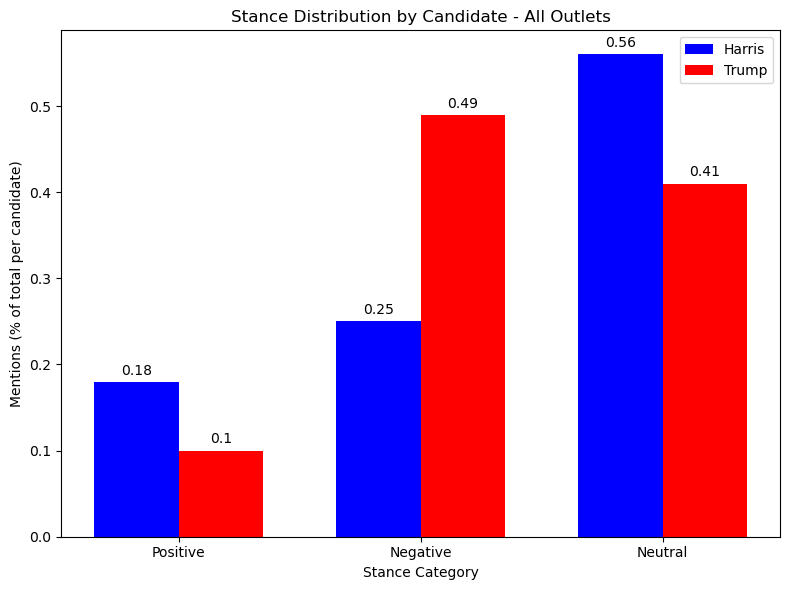

In [11]:
print('Detecção de posicionamento considerando rótulos em que os modelos foram unânimes:')
plot_outlet_coverage(harris_dict, trump_dict)

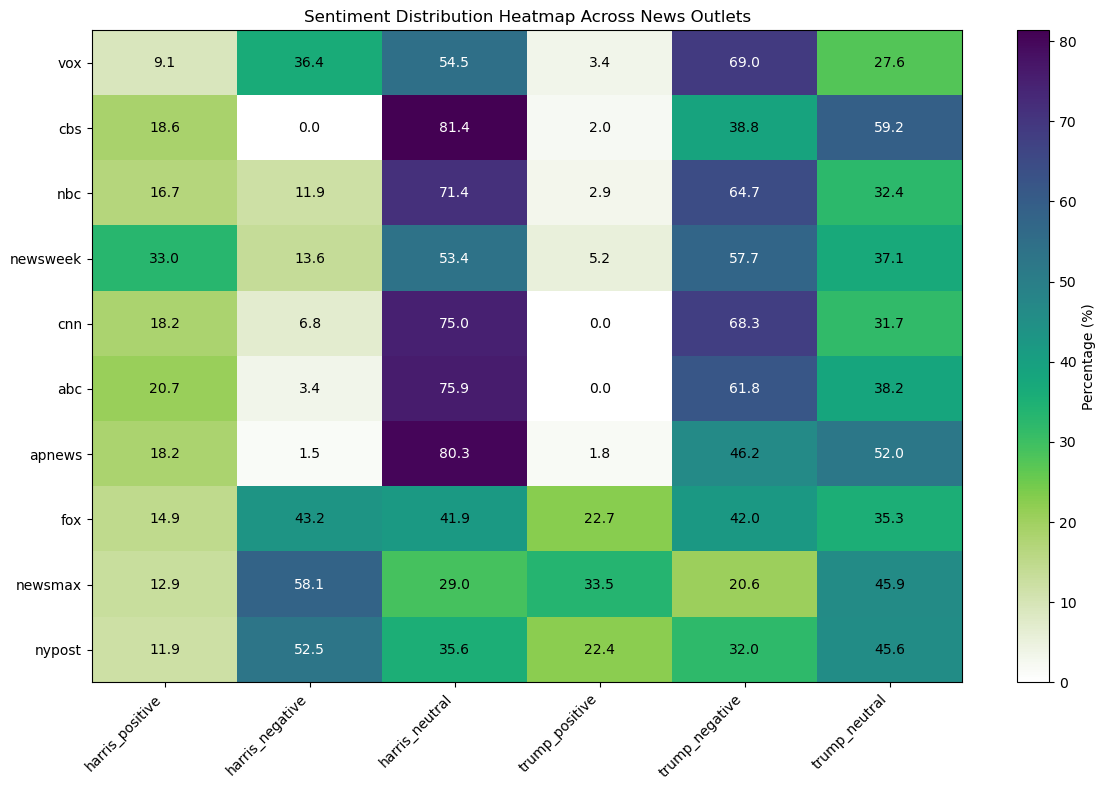

In [12]:
for outlet in outlets_dict:
    for candidate in outlets_dict[outlet]:
        for sentiment in ['positive', 'negative', 'neutral']:
            outlets_dict_normalized[outlet][candidate][sentiment] = (outlets_dict[outlet][candidate][sentiment] / outlets_dict[outlet][candidate]['total']) * 100

candidates = ['harris', 'trump']
sentiments = ['positive', 'negative', 'neutral']
heatmap_data = []

for outlet in outlets_list:
    row = []
    for candidate in candidates:
        for sentiment in sentiments:
            row.append(outlets_dict_normalized[outlet][candidate][sentiment])
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)

# Heatmap plot
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(heatmap_data, cmap=viridis_white_r, aspect='auto')

# Labels and ticks
ax.set_xticks(np.arange(len(candidates) * len(sentiments)))
ax.set_xticklabels([f"{cand}_{sent}" for cand in candidates for sent in sentiments], rotation=45, ha="right")
ax.set_yticks(np.arange(len(outlets_list)))
ax.set_yticklabels(outlets_list)
ax.set_title("Sentiment Distribution Heatmap Across News Outlets")

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Percentage (%)')

# Annotate each cell with its value
for i in range(len(outlets_list)):
    for j in range(len(candidates) * len(sentiments)):
        value = heatmap_data[i, j]
        ax.text(j, i, f"{value:.1f}", ha="center", va="center", color="white" if value > 50 else "black")

plt.tight_layout()
plt.show()
